In [2]:
# Needed to import modules from helpers
import sys
import os

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [13]:
import torch
import esm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from helpers import helper
import time

# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

### Hypothesis 1:

The model learns to group proteins based on their evolutionary relationship (homology). Proteins belonging to the same sequence family (orthologs) are expected to lie close to one another in the embedding space, even if their sequences have diverged due to mutations.

While the organization of proteins in the representation space is diffuse prior to training, we expect clear clusters to emerge after training, reflecting evolutionary relationships.

### Method:

Each protein (sequence x) is processed by the Transformer model. We extract the final hidden representation for each amino acid token. To obtain a single vector representation for the entire protein, we average these values across the sequence length (mean pooling).​	
 
This process projects each sequence as a single point in a high-dimensional space. To visualize this high-dimensional structure, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the embeddings onto two dimensions for analysis

In [4]:
genes = [
    #"HBA", "HBB", "MB", "NGB",   # Die Globin-Familie
    "TP53",                      # Outgroup (Krebsforschung)
    "GAPDH",                     # Stoffwechsel (Enzym)
    "ACTB",                      # Zytoskelett (extrem konserviert!)
    "INS"                        # Signalhormon (Insulin)
]

# Lateinische Namen
organisms = {
    "Homo sapiens",
    "Pan troglodytes",
    "Gorilla gorilla",
    "Mus musculus",
    "Rattus norvegicus",
    "Canis lupus familiaris",
    "Felis catus",
    "Bos taurus",
    "Sus scrofa",
    "Ovis aries"
    #"Gallus gallus", # Chicken
    #"Anolis carolinensis",
    #"Chelonia mydas",      # Meeresschildkröte
    #"Xenopus tropicalis",
    #"Salmo salar",         # Lachs
    #"Danio rerio"
}

sequences_dict = {}

for gene in genes:
    for org in organisms:
       
        seq = helper.fetch_uniprot_sequence(gene, org)
        
        if seq:
            # Key bauen 
            key = f"{gene}_{org}"
            sequences_dict[key] = seq
            
        # Kurz warten um die API nicht zu überlasten
        time.sleep(0.2)

print("\nDictionary erstellt!")
print(f"Anzahl geladener Sequenzen: {len(sequences_dict)}")

# Zur Kontrolle mal eine ausgeben
if "HBA_Human" in sequences_dict:
    print(f"\nBeispiel (HBA_Human Real Sequence): {sequences_dict['HBA_Human'][:50]}...")

⚠️ No result for TP53 in Gorilla gorilla
⚠️ No result for TP53 in Pan troglodytes
✅ Found TP53 in Bos taurus (ID: P67939)
✅ Found TP53 in Mus musculus (ID: P02340)
✅ Found TP53 in Canis lupus familiaris (ID: Q29537)
✅ Found TP53 in Felis catus (ID: P41685)
✅ Found TP53 in Homo sapiens (ID: P04637)
✅ Found TP53 in Ovis aries (ID: P51664)
✅ Found TP53 in Sus scrofa (ID: Q9TUB2)
✅ Found TP53 in Rattus norvegicus (ID: P10361)
⚠️ No result for GAPDH in Gorilla gorilla
⚠️ No result for GAPDH in Pan troglodytes
✅ Found GAPDH in Bos taurus (ID: P10096)
✅ Found GAPDH in Mus musculus (ID: P16858)
✅ Found GAPDH in Canis lupus familiaris (ID: Q28259)
✅ Found GAPDH in Felis catus (ID: Q9N2D5)
✅ Found GAPDH in Homo sapiens (ID: P04406)
✅ Found GAPDH in Ovis aries (ID: Q28554)
✅ Found GAPDH in Sus scrofa (ID: P00355)
✅ Found GAPDH in Rattus norvegicus (ID: P04797)
⚠️ No result for ACTB in Gorilla gorilla
✅ Found ACTB in Pan troglodytes (ID: Q5R1X3)
✅ Found ACTB in Bos taurus (ID: P60712)
✅ Found ACTB

In [5]:
labels_gene = [k.split('_')[0] for k in sequences_dict.keys()]
labels_species = [k.split('_')[1] for k in sequences_dict.keys()]
labels = list(sequences_dict.keys())
seqs = list(sequences_dict.values())

In [6]:
seqs

['MEESQAELNVEPPLSQETFSDLWNLLPENNLLSSELSAPVDDLLPYTDVATWLDECPNEAPQMPEPSAPAAPPPATPAPATSWPLSSFVPSQKTYPGNYGFRLGFLQSGTAKSVTCTYSPSLNKLFCQLAKTCPVQLWVDSPPPPGTRVRAMAIYKKLEHMTEVVRRCPHHERSSDYSDGLAPPQHLIRVEGNLRAEYLDDRNTFRHSVVVPYESPEIDSECTTIHYNFMCNSSCMGGMNRRPILTIITLEDSCGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGQSCPEPPPRSTKRALPTNTSSSPQPKKKPLDGEYFTLQIRGFKRYEMFRELNDALELKDALDGREPGESRAHSSHLKSKKRPSPSCHKKPMLKREGPDSD',
 'MTAMEESQSDISLELPLSQETFSGLWKLLPPEDILPSPHCMDDLLLPQDVEEFFEGPSEALRVSGAPAAQDPVTETPGPVAPAPATPWPLSSFVPSQKTYQGNYGFHLGFLQSGTAKSVMCTYSPPLNKLFCQLAKTCPVQLWVSATPPAGSRVRAMAIYKKSQHMTEVVRRCPHHERCSDGDGLAPPQHLIRVEGNLYPEYLEDRQTFRHSVVVPYEPPEAGSEYTTIHYKYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRDSFEVRVCACPGRDRRTEEENFRKKEVLCPELPPGSAKRALPTCTSASPPQKKKPLDGEYFTLKIRGRKRFEMFRELNEALELKDAHATEESGDSRAHSSYLKTKKGQSTSRHKKTMVKKVGPDSD',
 'MEESQSELNIDPPLSQETFSELWNLLPENNVLSSELCPAVDELLLPESVVNWLDEDSDDAPRMPATSAPTAPGPAPSWPLSSSVPSPKTYPGTYGFRLGFLHSGTAKSVTWTYSPLLNKLFCQLAKTCPVQLWVSSPPPPNTCVRAMAIYKKSEFVTEVVRRCPHHERCSDSSDGLAPPQHLIRVEGNLRAKYLDDRNTFRHSVVVPYEPPE

In [7]:
# 1. Embeddings mit dem TRAINIERTEN Modell holen
print("Berechne TRAINIERTE Embeddings...")
# Schritt 1: Hidden Representations holen
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)
# Schritt 2: Mean Pooling durchführen
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

Berechne TRAINIERTE Embeddings...


In [8]:
# 2. Embeddings mit einem zufälligen (UNTRAINIERTEN) Modell holen (natürlich ist hier ein Problem, 
# dass wir den seed nicht kennen alleine deshalb werden sich hier Sachen vom original Paper unterscheiden)
print("Berechne UNTRAINIERTE Embeddings...")
untrained_model = helper.randomize_model(model)
if torch.cuda.is_available(): 
    untrained_model = untrained_model.cuda()

# Schritt 1: Hidden Representations holen (mit untrainiertem Modell)
token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(untrained_model, alphabet, labels, seqs)
# Schritt 2: Mean Pooling durchführen
emb_untrained = helper.get_protein_embedding(token_reps_untrained, batch_strs_untrained)

Berechne UNTRAINIERTE Embeddings...


In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
emb_2d_untrained = tsne.fit_transform(emb_untrained)

tsne_trained = TSNE(n_components=2, perplexity=5, random_state=42, init='pca', learning_rate='auto')
emb_2d_trained = tsne_trained.fit_transform(emb_trained)

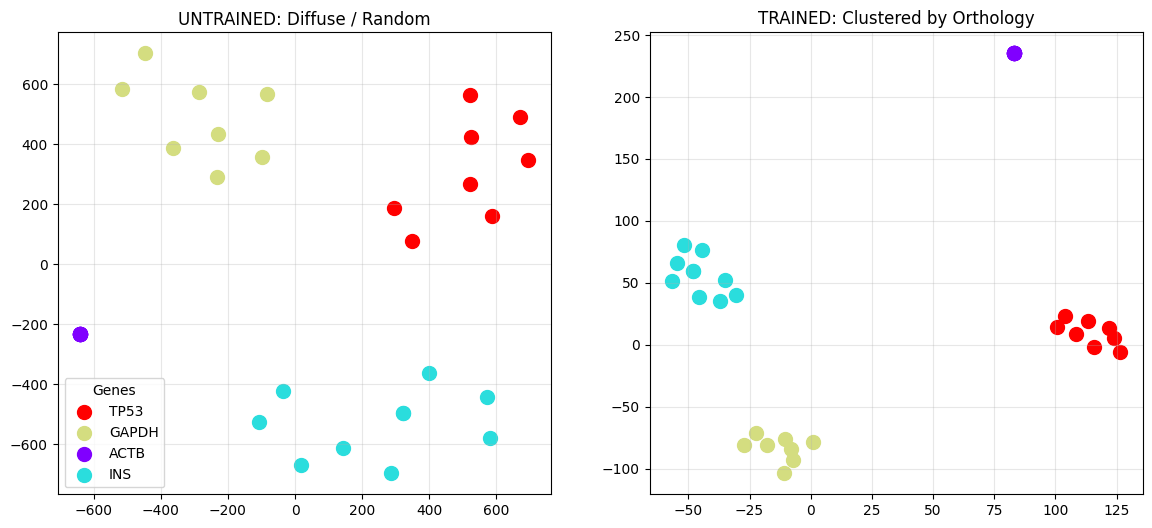

In [16]:
# Generate a unique color for each gene type
unique_genes = list(set([l.split('_')[0] for l in labels]))
colors = cm.rainbow(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# Setup Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- LEFT: Untrained ---
for i, label in enumerate(labels):
    gene_name = label.split('_')[0]
    species_name = label.split('_')[1]
    col = gene_color_map[gene_name]
    
    ax1.scatter(emb_2d_untrained[i, 0], emb_2d_untrained[i, 1], color=col, s=100, label=gene_name)
    # Optional: Add short text labels for species
    # ax1.text(emb_2d_untrained[i, 0], emb_2d_untrained[i, 1], species_name[:3], fontsize=8)

# Remove duplicate legend entries
handles, labels_plot = ax1.get_legend_handles_labels()
by_label = dict(zip(labels_plot, handles))
ax1.legend(by_label.values(), by_label.keys(), title="Genes")
ax1.set_title("UNTRAINED: Diffuse / Random")
ax1.grid(True, alpha=0.3)

# --- RIGHT: Trained ---
for i, label in enumerate(labels):
    gene_name = label.split('_')[0]
    col = gene_color_map[gene_name]
    ax2.scatter(emb_2d_trained[i, 0], emb_2d_trained[i, 1], color=col, s=100)

ax2.set_title("TRAINED: Clustered by Orthology")
ax2.grid(True, alpha=0.3)

plt.show()

Hypothesis 2: unsupervised learning encodes biological variations into the structure of the representation space. Das Modell lernt also ohne explizite Labels, fundamentale biologische Unterscheidungen zwischen species und gen familie

Die Autoren wenden eine Hauptkomponentenanalyse (PCA) auf die gelernten Repräsentationen von vier orthologen Genen über vier verschiedene Spezies hinweg an

Beobachtung: Die PCA enthüllt, dass das trainierte Modell automatisch Achsen bildet, die biologisch interpretierbar sind:
- Eine Spezies-Achse (horizontal), die Organismen unterscheidet.
- Eine Orthologie-Achse (vertikal), die Gene unterscheidet.

Vergleich: Diese Struktur fehlt in untrainierten Modellen oder simplen Unigram-Modellen komplett.

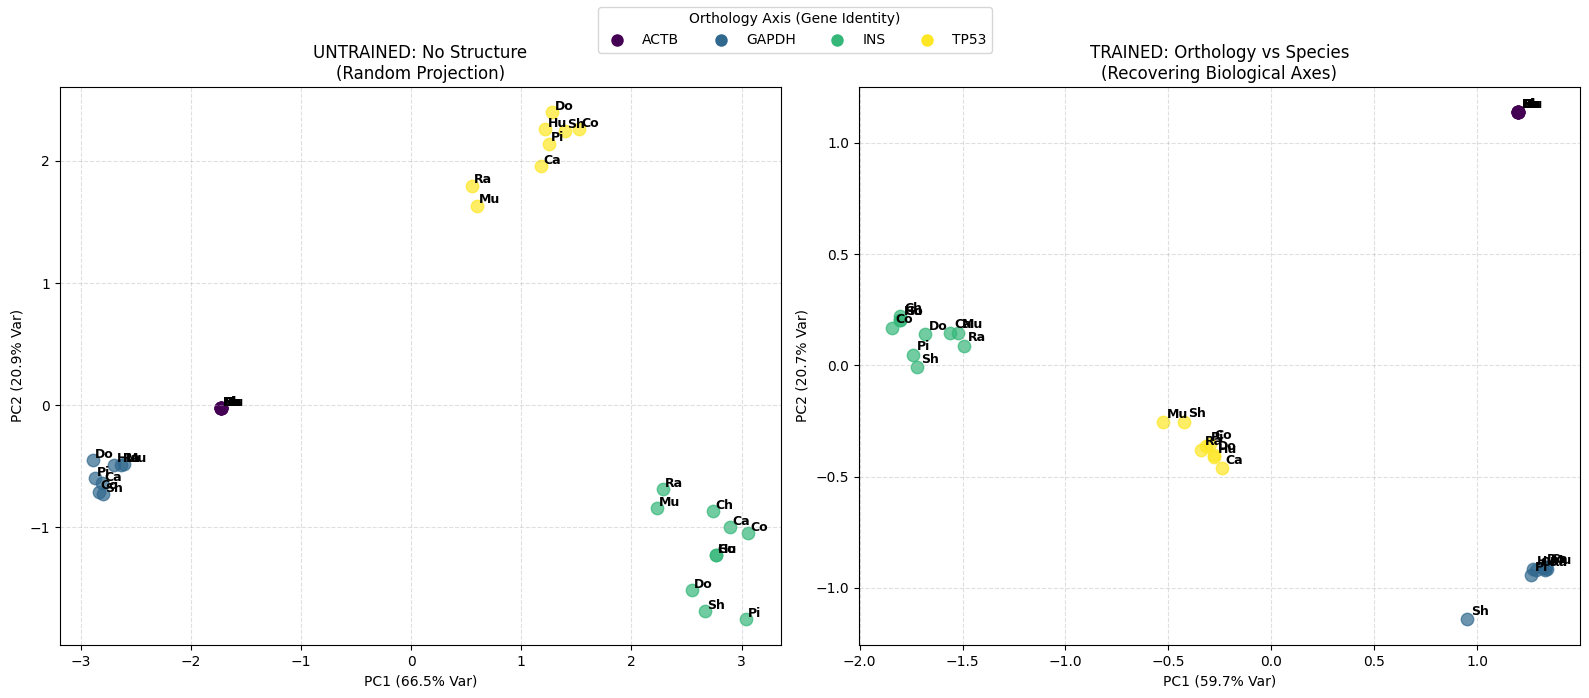

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA

# Generate consistent colors for Genes (The "Orthology Axis")
unique_genes = sorted(list(set([l.split('_')[0] for l in labels])))
colors = cm.viridis(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# Generate short labels for Species (The "Species Axis")
# Mapping Latin names to short codes for cleaner plotting like Fig 2B
unique_species = sorted(list(set([l.split('_')[1] for l in labels])))
species_code_map = {
    "Homo sapiens": "Hu",
    "Pan troglodytes": "Ch",
    "Gorilla gorilla": "Go",
    "Mus musculus": "Mu",
    "Rattus norvegicus": "Ra",
    "Canis lupus familiaris": "Do",
    "Felis catus": "Ca",
    "Bos taurus": "Co",
    "Sus scrofa": "Pi",
    "Ovis aries": "Sh"
}

def plot_pca_custom(ax, embeddings, title, label_list):
    # 1. Compute PCA
    pca = PCA(n_components=2)
    emb_pca = pca.fit_transform(embeddings)
    var = pca.explained_variance_ratio_
    
    # 2. Plot points
    for i, full_label in enumerate(label_list):
        # Parse: The previous script constructed keys as "Gene_Organism"
        parts = full_label.split('_')
        gene_name = parts[0]
        species_name = parts[1]
        
        # Get style
        c = gene_color_map.get(gene_name, 'gray')
        txt = species_code_map.get(species_name, species_name[:2]) # Fallback to first 2 chars
        
        # Scatter point
        ax.scatter(emb_pca[i, 0], emb_pca[i, 1], color=c, s=80, alpha=0.7)
        
        # Add text label to show the "Species Axis"
        ax.text(emb_pca[i, 0]+0.02, emb_pca[i, 1]+0.02, txt, fontsize=9, fontweight='bold')

    # 3. Styling
    ax.set_title(title)
    ax.set_xlabel(f"PC1 ({var[0]:.1%} Var)")
    ax.set_ylabel(f"PC2 ({var[1]:.1%} Var)")
    ax.grid(True, linestyle='--', alpha=0.4)

# --- 2. EXECUTE PLOTTING ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# LEFT: Untrained (Control)
# Expectation: Random distribution, no clear separation of species or genes [cite: 239]
plot_pca_custom(ax1, emb_untrained, "UNTRAINED: No Structure\n(Random Projection)", labels)

# RIGHT: Trained (ESM)
# Expectation: Grid-like structure. Genes cluster (Color), Species align (Text) [cite: 240, 242]
plot_pca_custom(ax2, emb_trained, "TRAINED: Orthology vs Species\n(Recovering Biological Axes)", labels)

# --- 3. LEGEND ---
legend_elements = [Line2D([0], [0], marker='o', color='w', label=gene,
                          markerfacecolor=color, markersize=10) 
                   for gene, color in gene_color_map.items()]

fig.legend(handles=legend_elements, loc='upper center', ncol=len(unique_genes), 
           title="Orthology Axis (Gene Identity)")

plt.tight_layout()
plt.subplots_adjust(top=0.88) # Adjust for legend space
plt.show()

Hypothesis 3: biological properties are encoded along independent directions in the representation space

Then if we have two related sequences which only distiguish themselves by one unique property, they should only be differing along one of these separate axes

Analogy: 

o	Vector arithmetics in NLP: King – Royalty = Queen 

Vector arithmetics in Biology: Hemoglobin - Rat = .. 

-	In SI Appendix, Fig. S1, we find that learning improves recovery of target proteins under queries encoded as linear transformations along the species or gene axes
o	•  "Queries encoded as linear transformations...": Das ist die "Rechen-Anfrage". Die Forscher haben genau das getan, was wir besprochen haben:
o	Beispiel (species axis): Sie haben den Vektor-Unterschied zwischen zwei Spezies berechnet, z.B. .
o	Dann haben sie eine "query" (Anfrage) gestellt: 
o	•  "Target proteins": Das ist die korrekte Antwort auf die Rechen-Anfrage. In unserem Beispiel wäre das "target protein" das Maus-Hämoglobin.
o	•  "Recovery of target proteins": Das bedeutet "das korrekte Ziel-Protein finden".
o	Das Modell macht die Rechnung () und erhält einen Ergebnis-Vektor.
o	Dann schaut es im gesamten Datensatz nach: Welches "echte" Protein-Embedding liegt diesem Ergebnis-Vektor am nächsten?
o	Wenn es "Maus-Hämoglobin" findet, war die "recovery" erfolgreich.
o	•  "Learning improves recovery...": Das ist das Ergebnis.
o	Bei einem untrainierten Modell (vor dem "learning") ist das Ergebnis dieser Rechnung Müll. Es findet das "target protein" nicht.
o	Bei einem trainierten Modell (nach dem "learning") funktioniert die Rechnung. Das Modell "recovers" (findet) das korrekte "target protein" (Maus-Hämoglobin) mit hoher Genauigkeit.

Vector(Human Insulin)−Vector(Human)+Vector(Mouse)≈Vector(Mouse Insulin)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. PREPARATION: Calculate "Mean Species Vectors" ---
# We need to know what "Human-ness" or "Mouse-ness" looks like on average.
# This defines our axes.

species_centroids = {}
unique_species = list(set([l.split('_')[1] for l in labels]))

for species in unique_species:
    # Get indices of all sequences belonging to this species
    indices = [i for i, label in enumerate(labels) if species in label]
    
    # Compute the average (centroid) embedding for this species
    if indices:
        # axis=0 computes the mean vector across the selected sequences
        centroid = np.mean(emb_trained[indices], axis=0) 
        species_centroids[species] = centroid

print("Calculated Species Centroids (Axes).")

# --- 2. DEFINE THE ARITHMETIC FUNCTION ---

def perform_vector_arithmetic(gene_name, source_species, target_species, embeddings, label_list):
    """
    Performs: Source_Gene - Source_Species + Target_Species = Predicted_Target_Gene
    Then checks if the Predicted_Target_Gene is close to the REAL Target_Gene.
    """
    
    # 1. Find the Source Vector (e.g., Vector(INS_Human))
    source_label = f"{gene_name}_{source_species}"
    if source_label not in label_list:
        return f"Skipping: {source_label} not found."
    
    source_idx = label_list.index(source_label)
    vec_source_gene = embeddings[source_idx]
    
    # 2. Find the Species Vectors (Axes)
    vec_source_species = species_centroids[source_species]
    vec_target_species = species_centroids[target_species]
    
    # 3. THE ARITHMETIC (The "Magic" Step)
    # "Take the human gene, subtract human-ness, add mouse-ness"
    # Logic: King - Man + Woman = Queen
    vec_prediction = vec_source_gene - vec_source_species + vec_target_species
    
    # 4. SEARCH (Recovery)
    # Look at ALL embeddings to find which one is closest to our prediction
    # We use Cosine Similarity for this
    
    # Reshape for sklearn (needs 2D array)
    vec_prediction = vec_prediction.reshape(1, -1)
    
    # Calculate similarity to ALL sequences in our database
    similarities = cosine_similarity(vec_prediction, embeddings)[0]
    
    # Sort indices by similarity (highest first)
    ranked_indices = np.argsort(similarities)[::-1]
    
    # 5. CHECK RESULT
    # We want to see where the REAL target (e.g., INS_Mouse) is ranked
    target_label = f"{gene_name}_{target_species}"
    
    print(f"\n--- Arithmetic: {gene_name} ({source_species} -> {target_species}) ---")
    print(f"Formula: Vector({source_label}) - Vector({source_species}) + Vector({target_species})")
    
    found_target = False
    for rank, idx in enumerate(ranked_indices[:5]): # Show top 5 matches
        match_label = label_list[idx]
        score = similarities[idx]
        
        prefix = "   "
        if match_label == target_label:
            prefix = ">>>" # HIT!
            found_target = True
            
        print(f"{prefix} Rank {rank+1}: {match_label} (Sim: {score:.4f})")
        
    if not found_target:
        # If not in top 5, find where it actually is
        try:
            real_target_idx = label_list.index(target_label)
            # Find the rank of the real target
            real_rank = np.where(ranked_indices == real_target_idx)[0][0] + 1
            print(f"   ... Real Target ({target_label}) found at Rank {real_rank}")
        except ValueError:
            print(f"   (Target {target_label} not in database)")

# --- 3. RUN EXPERIMENTS ---

# Example 1: Can we turn Human Insulin into Mouse Insulin?
perform_vector_arithmetic("INS", "Homo sapiens", "Mus musculus", emb_trained, labels)

# Example 2: Can we turn Cow Cyto-globin into Human Cyto-globin?
# (Assuming we have these in the list, e.g. CYGB or similar)
# If you used different gene names in your list, adjust "GAPDH" or "TP53" below:
perform_vector_arithmetic("TP53", "Bos taurus", "Homo sapiens", emb_trained, labels)

# --- 4. CONTROL GROUP (Untrained Model) ---
print("\n" + "="*60)
print("CONTROL EXPERIMENT (Untrained Model)")
print("Does the arithmetic work without learning?")
print("="*60)
perform_vector_arithmetic("INS", "Homo sapiens", "Mus musculus", emb_untrained, labels)

Calculated Species Centroids (Axes).

--- Arithmetic: INS (Homo sapiens -> Mus musculus) ---
Formula: Vector(INS_Homo sapiens) - Vector(Homo sapiens) + Vector(Mus musculus)
    Rank 1: INS_Gorilla gorilla (Sim: 0.9992)
    Rank 2: INS_Homo sapiens (Sim: 0.9992)
    Rank 3: INS_Pan troglodytes (Sim: 0.9990)
>>> Rank 4: INS_Mus musculus (Sim: 0.9936)
    Rank 5: INS_Rattus norvegicus (Sim: 0.9930)

--- Arithmetic: TP53 (Bos taurus -> Homo sapiens) ---
Formula: Vector(TP53_Bos taurus) - Vector(Bos taurus) + Vector(Homo sapiens)
    Rank 1: TP53_Bos taurus (Sim: 0.9988)
>>> Rank 2: TP53_Homo sapiens (Sim: 0.9971)
    Rank 3: TP53_Canis lupus familiaris (Sim: 0.9970)
    Rank 4: TP53_Rattus norvegicus (Sim: 0.9968)
    Rank 5: TP53_Ovis aries (Sim: 0.9967)

CONTROL EXPERIMENT (Untrained Model)
Does the arithmetic work without learning?

--- Arithmetic: INS (Homo sapiens -> Mus musculus) ---
Formula: Vector(INS_Homo sapiens) - Vector(Homo sapiens) + Vector(Mus musculus)
    Rank 1: INS_Goril